# 自动求导
### 什么是自动求导
自动求导(AUTOMATIC DIFFERENTIATION 简称 AD) 或许是目前你从未听过且最有用的计算技术之一。如果你的工作涉及到实数计算，那么理解 AD 或许将会对你的工作有所帮助。  
自动求导，也被称为算法求导(algorithmic differentiation)或计算求导(computational differentiation)，是一组使用数值方法对某个函数，通过编程的方式进行求导的技术。可以求任意阶的导数，求导过程是自动的，并且能够保证足够的精度，以及较小的时间复杂度。

torch.autograd是 PyTorch 的自动差分引擎，可为神经网络训练提供支持。 在本节中，您将获得有关 Autograd 如何帮助神经网络训练的概念性理解

### 背景
神经网络（NN）是在某些输入数据上执行的嵌套函数的集合。 这些函数由参数（由权重和偏差组成）定义，这些参数在 PyTorch 中存储在张量中。

训练 NN 分为两个步骤：
* 正向传播：在正向传播中，NN 对正确的输出进行最佳猜测。 它通过其每个函数运行输入数据以进行猜测。
* 反向传播：在反向传播中，NN 根据其猜测中的误差调整其参数。 它通过从输出向后遍历，收集有关函数参数（梯度）的误差导数并使用梯度下降来优化参数来实现。

让我们来看一个训练步骤。 对于此示例，我们从torchvision加载了经过预训练的 resnet18 模型。 我们创建一个随机数据张量来表示具有 3 个通道的单个图像，高度&宽度为 64，其对应的label初始化为一些随机值。

In [14]:
import torch, torchvision
model = torchvision.models.resnet18(pretrained=True)
data = torch.rand(1, 3, 64, 64)
labels = torch.rand(1, 1000)



接下来，我们通过模型的每一层运行输入数据以进行预测。 这是正向传播。

In [15]:
prediction = model(data) # 正向传播


我们使用模型的预测和相应的标签来计算误差（loss）。 下一步是通过网络反向传播此误差。 当我们在误差张量上调用.backward()时，开始反向传播。 然后，Autograd 会为每个模型参数计算梯度并将其存储在参数的.grad属性中。

In [16]:
loss = (prediction - labels).sum()
loss.backward() # 反向传播

接下来，我们加载一个优化器，在本例中为 SGD（随机梯度下降），学习率为 0.01，动量为 0.9。 我们在优化器中注册模型的所有参数。

In [17]:
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

最后，我们调用.step()启动梯度下降。 优化器通过.grad中存储的梯度来调整每个参数。

In [18]:
optim.step() #梯度下降


## Autograd 的微分
让我们来看看autograd如何收集梯度。 我们用requires_grad=True创建两个张量a和b。 这向autograd发出信号，应跟踪对它们的所有操作。

In [27]:
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

我们从a和b创建另一个张量Q。  
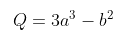

In [28]:
Q = 3*a**3 - b**2

假设a和b是神经网络的参数，Q是误差。 在 NN 训练中，我们想要相对于参数的误差，即  
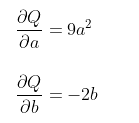

当我们在Q上调用.backward()时，Autograd 将计算这些梯度并将其存储在各个张量的.grad属性中。

我们需要在Q.backward()中显式传递gradient参数，因为它是向量。 gradient是与Q形状相同的张量，它表示Q相对于本身的梯度，即

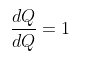

同样，我们也可以将Q聚合为一个标量，然后隐式地向后调用，例如Q.sum().backward()。

In [29]:
external_grad = torch.tensor([1., 1.])
Q.backward(gradient=external_grad)

梯度现在沉积在a.grad和b.grad中

In [32]:
# check if collected gradients are correct
print(9*a**2 == a.grad)
print(-2*b == b.grad)



tensor([True, True])
tensor([True, True])


======================================================================================================================================================================================

假设我们想对函数y=2x^Tx关于列向量求导。

In [19]:
import torch

x=torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

在计算y关于x的梯度之前，我们需要一个地方来存储梯度。（梯度的本意是一个向量，表示某函数在该点处的方向导数沿该方向取得最大值，即函数在该点处沿着该方向（此梯度的方向）变化最快，变化率最大（为该梯度的模）。）

In [20]:
x.requires_grad_(True)
x.grad #x的梯度默认值是None

计算y

In [21]:
y=2*torch.dot(x,x)
y

tensor(28., grad_fn=<MulBackward0>)

通过调用反向传播函数来自动计算y关于x每个分量的梯度

In [22]:
y.backward() #这里反向转播就是自动求导y=2*x*x求导后为4*x
x.grad

tensor([ 0.,  4.,  8., 12.])

In [23]:
#所以这里可以验证一下
x.grad==4*x

tensor([True, True, True, True])

计算x的另一个函数

In [24]:
#在默认情况下，Pytorch会累积梯度，我们需要清除之前的值
x.grad.zero_()
y=x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

深度学习中，我们的目的不是计算微分矩阵，而是批量中每个样本单独计算的偏导数之和。

In [25]:
x.grad.zero_()
y=x*x
y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

将某些计算移到记录的计算图之外

In [26]:
x.grad.zero_()
y=x*x
u=y.detach() #这里相当于对y进行不对x进行求导，相当于把u变成了一个常数
z=u*x
z.sum().backward()
x.grad==u

tensor([True, True, True, True])